<a href="https://colab.research.google.com/github/chaeyun22/Deeplearning-Project/blob/main/Baseline(DenseNet%2C_EfficientNet%2C_VGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


## 데이터 전처리

In [3]:
# train, valid, test로 분리
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import random

# 데이터셋 디렉토리 경로
dataset_dir = '/content/drive/MyDrive/garbage_images'

# 클래스 레이블과 해당 폴더의 이미지 경로 가져오기
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
image_paths = []

for label in class_labels:
    folder_path = os.path.join(dataset_dir, label)
    images = os.listdir(folder_path)
    images = [os.path.join(folder_path, image) for image in images]
    image_paths.extend(images)

# 전처리된 이미지 데이터와 클래스 레이블을 Tensor로 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 전체 데이터셋을 로드
dataset = torchvision.datasets.ImageFolder(dataset_dir, transform=transform)

# 데이터셋을 train, test, valid로 나누기 위해 인덱스 생성
num_data = len(dataset)
indices = list(range(num_data))

split_ratio = [0.6, 0.2, 0.2]  # train, test, valid 데이터셋의 비율

random.shuffle(indices)  # 인덱스를 무작위로 섞음

train_split = int(num_data * split_ratio[0])
test_split = int(num_data * (split_ratio[0] + split_ratio[1]))

train_indices = indices[:train_split]
test_indices = indices[train_split:test_split]
valid_indices = indices[test_split:]

# Subset을 사용하여 train, test, valid 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
valid_dataset = Subset(dataset, valid_indices)

# 데이터로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# for images, labels in valid_loader:
#     print(labels)

## DenseNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121

# DenseNet 모델 불러오기
model = densenet121(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.7MB/s]


In [ ]:
# 모델 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct / total

    return train_loss, train_acc

# 모델 평가 함수
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    eval_loss /= len(data_loader)
    eval_acc = correct / total

    return eval_loss, eval_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 10
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)

    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Epoch 1/10
Train Loss: 0.8538 | Train Acc: 0.6959
Eval Loss: 1.7869 | Eval Acc: 0.4704
---------------------------------------
Epoch 2/10
Train Loss: 0.5516 | Train Acc: 0.8120
Eval Loss: 3.1174 | Eval Acc: 0.3399
---------------------------------------
Epoch 3/10
Train Loss: 0.3920 | Train Acc: 0.8648
Eval Loss: 1.0946 | Eval Acc: 0.6383
---------------------------------------
Epoch 4/10
Train Loss: 0.3464 | Train Acc: 0.8839
Eval Loss: 1.5802 | Eval Acc: 0.5277
---------------------------------------
Epoch 5/10
Train Loss: 0.2913 | Train Acc: 0.8925
Eval Loss: 0.8894 | Eval Acc: 0.7312
---------------------------------------
Epoch 6/10
Train Loss: 0.2295 | Train Acc: 0.9248
Eval Loss: 0.7721 | Eval Acc: 0.7431
---------------------------------------
Epoch 7/10
Train Loss: 0.2384 | Train Acc: 0.9268
Eval Loss: 0.8471 | Eval Acc: 0.7273
---------------------------------------
Epoch 8/10
Train Loss: 0.2635 | Train Acc: 0.9136
Eval Loss: 0.7684 | Eval Acc: 0.7708
------------------------

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

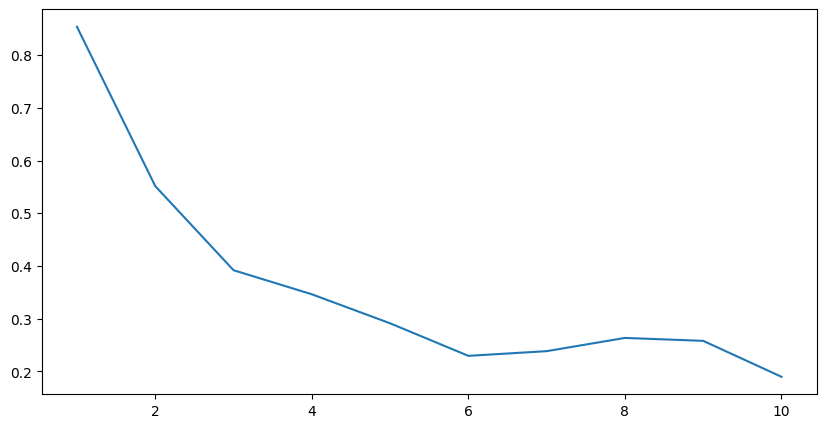

In [ ]:
# Train loss 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot

## EfficientNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# EfficientNet 모델 불러오기
model = efficientnet_b0(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.5MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 10
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    # print(f'Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Epoch 1/10
Train Loss: 0.7385 | Train Acc: 0.7487
Eval Loss: 0.6419
---------------------------------------
Epoch 2/10
Train Loss: 0.3295 | Train Acc: 0.8951
Eval Loss: 0.4435
---------------------------------------
Epoch 3/10
Train Loss: 0.1958 | Train Acc: 0.9360
Eval Loss: 0.5113
---------------------------------------
Epoch 4/10
Train Loss: 0.1558 | Train Acc: 0.9459
Eval Loss: 0.4237
---------------------------------------
Epoch 5/10
Train Loss: 0.1585 | Train Acc: 0.9466
Eval Loss: 0.4016
---------------------------------------
Epoch 6/10
Train Loss: 0.1766 | Train Acc: 0.9406
Eval Loss: 0.5125
---------------------------------------
Epoch 7/10
Train Loss: 0.1265 | Train Acc: 0.9631
Eval Loss: 0.3402
---------------------------------------
Epoch 8/10
Train Loss: 0.1040 | Train Acc: 0.9677
Eval Loss: 0.3393
---------------------------------------
Epoch 9/10
Train Loss: 0.0720 | Train Acc: 0.9802
Eval Loss: 0.3339
---------------------------------------
Epoch 10/10
Train Loss: 0.08

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

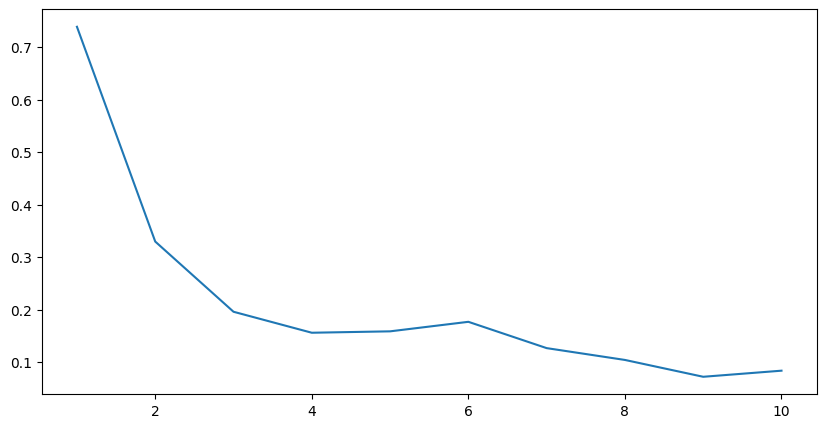

In [ ]:
# Train loss 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot

## VGG

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
import matplotlib.pyplot as plt

# VGG 모델 불러오기
model = vgg19(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)

for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 10
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    # print(f'Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Epoch 1/10
Train Loss: 1.7835 | Train Acc: 0.2150
Eval Loss: 2.9814
---------------------------------------
Epoch 2/10
Train Loss: 1.7540 | Train Acc: 0.2051
Eval Loss: 1.7671
---------------------------------------
Epoch 3/10
Train Loss: 1.7310 | Train Acc: 0.2131
Eval Loss: 1.7485
---------------------------------------
Epoch 4/10
Train Loss: 1.7370 | Train Acc: 0.2032
Eval Loss: 1.7263
---------------------------------------
Epoch 5/10
Train Loss: 1.7359 | Train Acc: 0.2012
Eval Loss: 1.7270
---------------------------------------
Epoch 6/10
Train Loss: 1.7330 | Train Acc: 0.1946
Eval Loss: 1.7427
---------------------------------------
Epoch 7/10
Train Loss: 1.7299 | Train Acc: 0.2025
Eval Loss: 1.7313
---------------------------------------
Epoch 8/10
Train Loss: 1.7296 | Train Acc: 0.1992
Eval Loss: 1.7479
---------------------------------------
Epoch 9/10
Train Loss: 1.7263 | Train Acc: 0.2051
Eval Loss: 1.7317
---------------------------------------
Epoch 10/10
Train Loss: 1.72

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

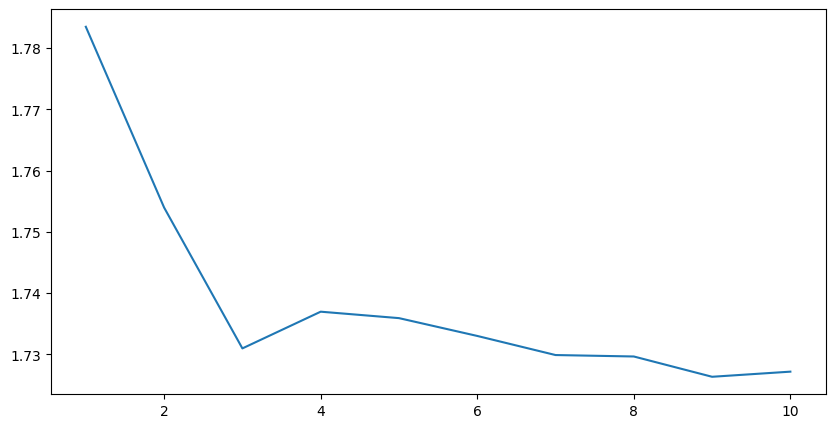

In [ ]:
# Train loss 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot